Import des librairies necessaires

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import VGG16_Weights

Preprocessing

In [2]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.GaussianBlur(5),
    transforms.Grayscale(num_output_channels=3),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
train_dataset = torchvision.datasets.ImageFolder(root='../dataset/Training/', transform=transform_train)
val_dataset = torchvision.datasets.ImageFolder(root='../dataset/Training/', transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Chargeons le modèle VGG16 pré-entraîné et modifier la dernière couche

In [4]:
vgg16 = torchvision.models.vgg16(weights=VGG16_Weights.DEFAULT)

num_classes = 4
vgg16.classifier[6] = nn.Linear(vgg16.classifier[6].in_features, num_classes)

torch.cuda.empty_cache()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vgg16 = vgg16.to(device)

Geler les paramètres des couches convolutives

In [5]:
for param in vgg16.features.parameters():
    param.requires_grad = False

Optimiseur

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier[6].parameters(), lr=0.001)

Entrainement

In [7]:
num_epochs = 30
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    
    #Validation
    vgg16.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
                
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    val_epoch_loss = val_running_loss / len(val_loader)
    val_epoch_accuracy = 100 * correct / total
        
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_accuracy)
    
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%')

Epoch [1/30], Loss: 0.8480, Accuracy: 66.53%
Validation Loss: 0.6656, Validation Accuracy: 74.77%
Epoch [2/30], Loss: 0.7889, Accuracy: 70.75%
Validation Loss: 0.7698, Validation Accuracy: 73.13%
Epoch [3/30], Loss: 0.7662, Accuracy: 72.51%
Validation Loss: 0.5568, Validation Accuracy: 79.95%
Epoch [4/30], Loss: 0.7840, Accuracy: 72.57%
Validation Loss: 0.7874, Validation Accuracy: 73.70%
Epoch [5/30], Loss: 0.7629, Accuracy: 73.53%
Validation Loss: 0.6636, Validation Accuracy: 77.47%
Epoch [6/30], Loss: 0.8120, Accuracy: 72.57%
Validation Loss: 0.6472, Validation Accuracy: 77.70%
Epoch [7/30], Loss: 0.8388, Accuracy: 71.71%
Validation Loss: 0.7563, Validation Accuracy: 75.75%
Epoch [8/30], Loss: 0.8267, Accuracy: 73.06%
Validation Loss: 0.7187, Validation Accuracy: 76.65%
Epoch [9/30], Loss: 0.8306, Accuracy: 73.21%
Validation Loss: 0.6719, Validation Accuracy: 77.42%
Epoch [10/30], Loss: 0.8332, Accuracy: 72.78%
Validation Loss: 0.5570, Validation Accuracy: 80.25%
Epoch [11/30], Loss

Visualisation métrique de l'entrainemnt

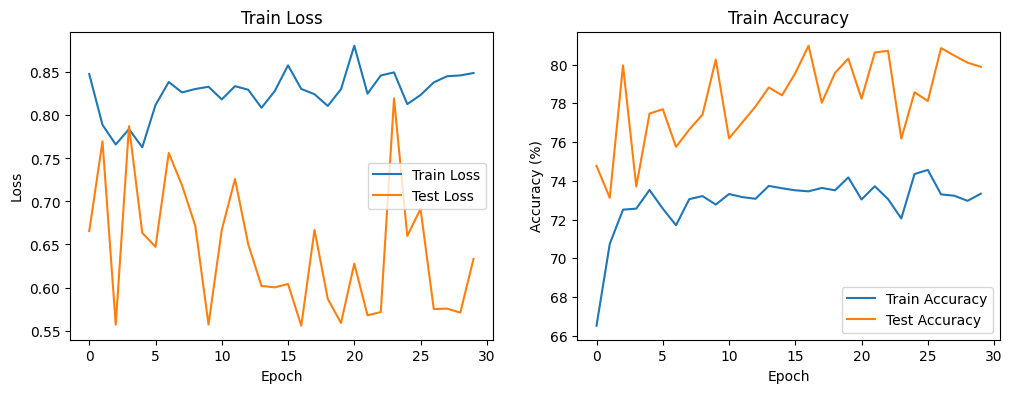

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Train Accuracy')

plt.show()

Métriques d'évaluations

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [10]:
all_preds = []
all_labels = []
all_scores = []

vgg16.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        scores = nn.functional.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_scores.extend(scores.cpu().numpy())


Matrice de confusion

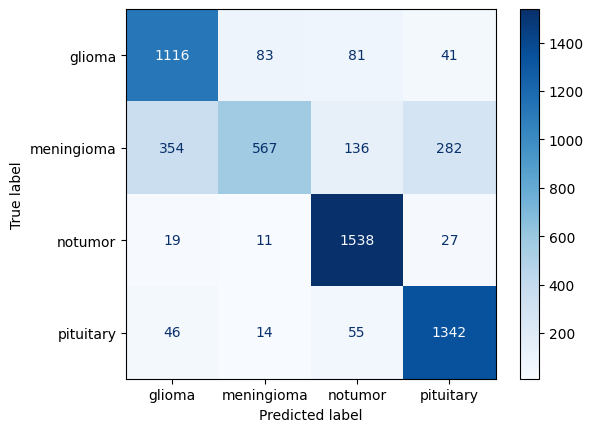

In [14]:
cm = confusion_matrix(all_labels, all_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

y_true = all_labels
y_pred = all_preds

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
roc_auc = roc_auc_score(y_true, all_scores, multi_class='ovr')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

Accuracy: 0.7988445378151261
Precision: 0.8024759488906987
Recall: 0.7883997216511318
F1-Score: 0.7750706638547485
ROC-AUC: 0.9512775352099148


Sauvegarde du modèle

In [13]:
torch.save(vgg16.state_dict(), 'tumor_model_transfer_learning.pth')